# Example: Inspecting a NeXus file

To demonstrate, that the `h5rdmtoolbox` works with NeXus files, we download one file and inspect it. Note, that with "work" we don't mean, that the data model of Nexus is understood by the toolbox. We would rather demonstrate, that we identify specific data in the file, plot it and apply a minimal example of convention, which we quickly design here.

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox.database.hdfdb import logger
logger.setLevel('DEBUG')

## 1. Get the file

In [2]:
import requests
r = requests.get('https://github.com/nexusformat/exampledata/raw/master/Soleil/hdf5/file_1.nxs')
with open('file.nxs', 'wb') as f:
    f.write(r.content)

## 2. Visit (Dump) the file

In [3]:
h5tbx.dump('file.nxs')

C:\Users\da4323\Documents\programming\GitHub\h5RDMtoolbox\h5rdmtoolbox\_repr.py:447: RuntimeWarning: Cannot decode attribute value for units
  warnings.warn(f'Cannot decode attribute value for {name}', RuntimeWarning)


## 3. Find and plot data

In [4]:
obj = h5tbx.database.FileDB('file.nxs').find_one({'$name': {'$basename': 'image#5'}},   
                                                 recursive=True)
obj

<LGroup "/NDX3_00021_ND__DLPC__00001/image#5" in "file.nxs">

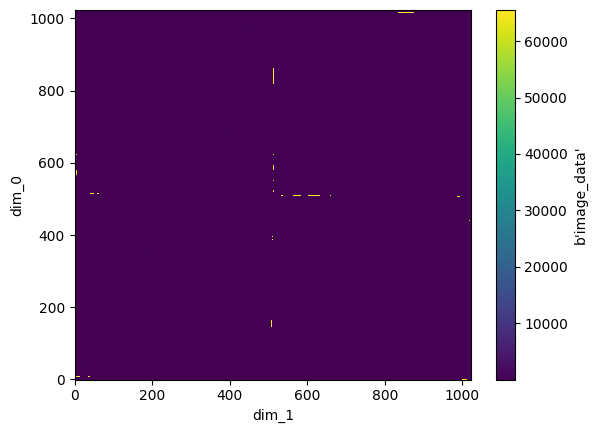

In [5]:
obj.data[()].plot()  # note, we can access children (e.g. dataset "data") of the (lazy) group

## 4. Write a standard attribute for timestamp

If you carefully check the `dump` output, you will find, that all numeric (!) datasets have the attribute "timestamp". All of them? Well, let's write a convention, which defines that providing the attribute "timestamp" with every numeric dataset is *required*. The timestamp value must have a specific format.

Let's create the standard name first:

### 4.1 Standard Name "timestamp"

In [6]:
from h5rdmtoolbox.conventions import StandardAttribute

from pydantic import BaseModel, ValidationError
from pydantic.functional_validators import AfterValidator, Annotated
from datetime import datetime
from typing import Union

def parse_datetime(v: Union[str, datetime]) -> str:
    """validation function used by the pydantic model class"""
    _format = '%Y-%m-%dT%H-%M-%S.%f'
    if isinstance(v, datetime):
        return v.strftime(_format)
    return datetime.strptime(v, _format).strftime(_format)

class NexusTimeStampObject(BaseModel):
    """The standard name table of the convention."""
    value: Annotated[str, AfterValidator(parse_datetime)]

NexusTimeStamp = StandardAttribute('timestamp',
                                   validator=NexusTimeStampObject,
                                   target_method='create_dataset',
                                   description='Timestamp of writing the data',
                                  default_value='$EMPTY')

### 4.2 Build the convention

In [7]:
from h5rdmtoolbox.conventions import Convention

cv = Convention(name='nexus', contact=h5tbx.__author__)

cv.add_standard_attribute(NexusTimeStamp)
cv.register()

h5tbx.use(cv)

using("nexus")

First test the convention on a temporary file:

In [8]:
with h5tbx.File() as h5:
    h5.create_dataset('test', data=4, timestamp='2008-10-23T15-09-39.175')
    h5.dump()

In [9]:
# should raise an error due to NO timestamp
with h5tbx.File() as h5:
    try:
        h5.create_dataset('test', data=4)
    except h5tbx.errors.StandardAttributeError as e:
        print(e)

Convention "nexus" expects standard attribute "timestamp" to be provided as an argument during dataset creation.


In [10]:
# should raise an error due to a wrong timestamp
with h5tbx.File() as h5:
    try:
        h5.create_dataset('test', data=4, timestamp='2008 10 23 15-09-39.175')
    except h5tbx.errors.StandardAttributeError as e:
        print(e)

The value "2008 10 23 15-09-39.175" for standard attribute "timestamp" could not be set. Please check the convention file wrt. the rule for this attribute. The following error message might not always explain the origin of the problem:
1 validation error for NexusTimeStampObject
value
  Value error, time data '2008 10 23 15-09-39.175' does not match format '%Y-%m-%dT%H-%M-%S.%f' [type=value_error, input_value='2008 10 23 15-09-39.175', input_type=str]
    For further information visit https://errors.pydantic.dev/2.5/v/value_error


### 4.3 Validate the NeXus file:

We find, that two datasets in fact have no timestamp!

In [11]:
invalid_objs = cv.validate('file.nxs')
invalid_objs

[{'name': '/NDX3_00021_ND__DLPC__00001/duration',
  'attr_name': 'timestamp',
  'reason': 'missing_attribute'},
 {'name': '/NDX3_00021_ND__DLPC__00001/run_number',
  'attr_name': 'timestamp',
  'reason': 'missing_attribute'}]

Let's convince ourselves:

In [12]:
obj = h5tbx.database.FileDB('file.nxs').find_one({'$name': invalid_objs[0]['name']})
obj.attrs.get('timestamp', 'missing!!!')

'missing!!!'

In [13]:
h5tbx.use(None)

using("h5py")